# Global Mean Sea Level Trend from Integrated Multi-Mission Ocean Altimeters TOPEX/Poseidon, Jason-1, OSTM/Jason-2, and Jason-3 Version 5.0

**Dataset**

https://doi.org/10.5067/GMSLM-TJ150

This dataset contains the Global Mean Sea Level (GMSL) trend generated from the Integrated Multi-Mission Ocean Altimeter Data for Climate Research Version 5. The GMSL trend is a 1-dimensional time series of globally averaged Sea Surface Height Anomalies (SSHA) from TOPEX/Poseidon, Jason-1, OSTM/Jason-2, and Jason-3 that covers September 1992 to present with a lag of up to 4 months. The data are reported as variations relative to a 20-year TOPEX/Jason collinear mean. Bias adjustments and cross-calibrations were applied to ensure SSHA data are consistent across the missions; Glacial Isostatic Adjustment (GIA) was also applied. The data are available as a table in ASCII format. Changes between the version 4.2 and version 5 releases are described in detail in the User Handbook ([https://doi.org/10.5067/ALTUG-TJ150](https://doi.org/10.5067/ALTUG-TJ150)).

**Citation**

    Beckley, B.; Yang, X.; Zelensky, N.P.; Holmes, S.A.;Lemoine, F.G.; Ray, R.D.; Mitchum, G.T.; Desai, S.; Brown, S.T.. 2020. Global Mean Sea Level Trend from Integrated Multi-Mission Ocean Altimeters TOPEX/Poseidon, Jason-1, OSTM/Jason-2, and Jason-3 Version 5.0. Ver. 5. PO.DAAC, CA, USA. Dataset accessed [YYYY-MM-DD] at https://doi.org/10.5067/GMSLM-TJ150.

***In this notebook***

You will learn how to download the ASCII table, load it into a [*pandas*](https://pandas.pydata.org/) data frame, and plot GMSL time series with [*matplotlib*](https://matplotlib.org/). Then, you will convert the data frame to an [*xarray*](https://xarray.pydata.org/) dataset, add some standard attributes for [CF compliance](https://cfconventions.org/), and write to netCDF4.

In [1]:
from datetime import datetime, timedelta
from os.path import basename
from io import StringIO
import urllib.request
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use('fast')

Print the OPeNDAP endpoint for the ASCII file and test that you have access by clicking the link shown below:

In [2]:
opendap_url = "https://opendap.jpl.nasa.gov/opendap/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level/GMSL_TPJAOS_5.0_199209_202009.txt"

print(opendap_url)

https://opendap.jpl.nasa.gov/opendap/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level/GMSL_TPJAOS_5.0_199209_202009.txt


Download the ASCII data file from the OPeNDAP endpoint shown above. Print the first line:

In [3]:
with urllib.request.urlopen(opendap_url) as f:
    data = f.read().decode('utf-8')

print(data.split("\n")[0])

HDR Global Mean Sea Level Data


## File

Every line of the header begins with the string `HDR`, followed by a whitespace. Identify the index of the final line of the header:

In [4]:
for ix, line in enumerate(data.split("\n")):
    if not line.startswith("HDR"):
        print(f"Index of the last line of the header:\t{ix}")
        print(f"Index of the first line of the data:\t{ix+1}")
        break

Index of the last line of the header:	48
Index of the first line of the data:	49


### Header

Split the `data` string into a list of lines and select the lines corresponding to the header. Display the header as a block of text:

In [5]:
lns = data.split("\n")
hdr = lns[:48]

print("\n".join(hdr))

HDR Global Mean Sea Level Data
HDR
HDR This file contains Global Mean Sea Level (GMSL) variations computed at the NASA Goddard Space Flight Center under the 
HDR auspices of the NASA Sea Level Change program. The GMSL was generated using the Integrated Multi-Mission Ocean Altimeter Data for 
HDR Climate Research (http://podaac.jpl.nasa.gov/dataset/MERGED_TP_J1_OSTM_OST_ALL_V5). It combines Sea Surface Heights from 
HDR TOPEX/Poseidon, Jason-1, OSTM/Jason-2, and Jason-3 to a common terrestrial reference frame with all inter-mission biases, range and 
HDR geophysical corrections applied and placed onto a georeferenced orbit. This creates a consistent data record throughout 
HDR time, regardless of the instrument used.
HDR
HDR The data can be found below. A separate figure file, Global_Sea_Level_Graph, was generated using the GMSL data (listed in 
HDR column 12 below) with the 60-day Gaussian type filter and having the Global Isostatic Adjustment (GIA) applied, with annual 
HDR and semi-a

Note the header content:

* Details about the dataset/collection are given in the upper portion of the header (above the line of `=`).
* Details about the data file, including descriptions/units for each column and a missing data flag, are given in the lower portion of the header.

In [6]:
column_metadata = [l[4:] for l in hdr[30:42]]

column_metadata

['1 altimeter type 0=dual-frequency  999=single frequency (ie Poseidon-1) ',
 '2 merged file cycle # ',
 '3 year+fraction of year (mid-cycle) ',
 '4 number of observations ',
 '5 number of weighted observations ',
 '6 GMSL (Global Isostatic Adjustment (GIA) not applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference ',
 '7 standard deviation of GMSL (GIA not applied) variation estimate (mm)',
 '8 smoothed (60-day Gaussian type filter) GMSL (GIA not applied) variation (mm)  ',
 '9 GMSL (Global Isostatic Adjustment (GIA) applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference ',
 '10 standard deviation of GMSL (GIA applied) variation estimate (mm)',
 '11 smoothed (60-day Gaussian type filter) GMSL (GIA applied) variation (mm)',
 '12 smoothed (60-day Gaussian type filter) GMSL (GIA applied) variation (mm); annual and semi-annual signal removed']

I chose the following column names based on the info shown above:

In [7]:
column_names = [
    'altimeter_type',
    'cycle', 
    'year',
    'observation_count', 
    'observation_count_weighted',
    'gmsl_variation',
    'gmsl_variation_std',
    'gmsl_variation_smooth',
    'gmsl_variation_with_gia',
    'gmsl_variation_with_gia_std',
    'gmsl_variation_with_gia_smooth',
    'gmsl_variation_with_gia_smooth_and_signals_removed',
]

### Data

Now load the data portion of the ASCII file into a [*pandas.DataFrame*](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

Everything after line 48 is data. Get the lines of the table as a separate list and display the first line:

In [8]:
lns = [l for l in lns[48:]]

print(lns[0])

  0   11  1993.0115260    452600 327401.31    -38.59     89.86    -38.76    -38.59     89.86    -38.75    -38.57


Join the list of lines into a big multiline string; make a `io.StringIO` object. Pass the object to the `pandas.read_fwf` convenience function:

In [9]:
df = pd.read_fwf(StringIO("\n".join(lns)), names=column_names, infer_nrows=len(lns))

df

,altimeter_type,cycle,year,observation_count,observation_count_weighted,gmsl_variation,gmsl_variation_std,gmsl_variation_smooth,gmsl_variation_with_gia,gmsl_variation_with_gia_std,gmsl_variation_with_gia_smooth,gmsl_variation_with_gia_smooth_and_signals_removed
0,0,11,1993.011526,452600,327401.31,-38.59,89.86,-38.76,-38.59,89.86,-38.75,-38.57
1,0,12,1993.038692,447591,324498.41,-41.97,90.86,-39.78,-41.97,90.86,-39.77,-39.11
2,0,13,1993.065858,459462,333018.19,-41.93,87.27,-39.62,-41.91,87.27,-39.61,-38.58
3,0,14,1993.093025,410064,297483.19,-42.67,90.75,-39.67,-42.65,90.74,-39.64,-38.34
4,0,15,1993.120191,446813,321635.81,-37.86,90.26,-38.75,-37.83,90.25,-38.72,-37.21
...,...,...,...,...,...,...,...,...,...,...,...,...
1014,0,1026,2020.567178,455026,333473.59,49.79,84.49,49.40,56.51,84.78,56.12,56.51
1015,0,1027,2020.594270,454770,334379.91,50.71,86.39,50.07,57.44,86.92,56.80,56.08
1016,0,1028,2020.621362,447970,330607.00,49.87,85.62,50.55,56.61,85.93,57.28,55.43
1017,0,1029,2020.648454,445963,330331.19,53.62,87.64,50.89,60.38,87.96,57.62,54.72


**Interpreting time (`year`)**

The time extent of the dataset in year fractions:

In [10]:
df.year.min(), df.year.max()

(1993.0115260000002, 2020.6755460000002)

A function to convert the fractional years to timestamps:

In [11]:
def _frac_year_to_dt(x):
    year = int(x)
    base = datetime(year, 1, 1)
    remainder = x - year
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * remainder)
    return result

(
    _frac_year_to_dt(df.year.min()).strftime("%Y-%m-%d %H:%M:%S"),
    _frac_year_to_dt(df.year.max()).strftime("%Y-%m-%d %H:%M:%S")
)

('1993-01-05 04:58:03', '2020-09-04 05:59:45')

Apply the new function `_frac_year_to_dt` to the `year` column of the data frame, which should return realistic  dates (between 1993 and 2020).

In [12]:
dates = df['year'].apply(_frac_year_to_dt)

dates

0      1993-01-05 04:58:03.936007
1      1993-01-15 02:56:30.912003
2      1993-01-25 00:54:57.887998
3      1993-02-03 22:53:56.399997
4      1993-02-13 20:52:23.375999
                  ...            
1014   2020-07-26 14:05:29.587200
1015   2020-08-05 12:04:03.647994
1016   2020-08-15 10:02:37.708803
1017   2020-08-25 08:01:11.769597
1018   2020-09-04 05:59:45.830405
Name: year, Length: 1019, dtype: datetime64[ns]

Rename the series to *time* so it doesn't conflict with the existing *year* column:

In [13]:
dates.name = "time"

*This next step is key for convenient data transformations and plotting.*

Now set the datetimes as the new index for the data frame using the `pandas.DataFrame.set_index` method, which replaces the existing integer indices:

In [14]:
df = df.set_index(dates)
df

,altimeter_type,cycle,year,observation_count,observation_count_weighted,gmsl_variation,gmsl_variation_std,gmsl_variation_smooth,gmsl_variation_with_gia,gmsl_variation_with_gia_std,gmsl_variation_with_gia_smooth,gmsl_variation_with_gia_smooth_and_signals_removed
time,,,,,,,,,,,,
1993-01-05 04:58:03.936007,0,11,1993.011526,452600,327401.31,-38.59,89.86,-38.76,-38.59,89.86,-38.75,-38.57
1993-01-15 02:56:30.912003,0,12,1993.038692,447591,324498.41,-41.97,90.86,-39.78,-41.97,90.86,-39.77,-39.11
1993-01-25 00:54:57.887998,0,13,1993.065858,459462,333018.19,-41.93,87.27,-39.62,-41.91,87.27,-39.61,-38.58
1993-02-03 22:53:56.399997,0,14,1993.093025,410064,297483.19,-42.67,90.75,-39.67,-42.65,90.74,-39.64,-38.34
1993-02-13 20:52:23.375999,0,15,1993.120191,446813,321635.81,-37.86,90.26,-38.75,-37.83,90.25,-38.72,-37.21
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-26 14:05:29.587200,0,1026,2020.567178,455026,333473.59,49.79,84.49,49.40,56.51,84.78,56.12,56.51
2020-08-05 12:04:03.647994,0,1027,2020.594270,454770,334379.91,50.71,86.39,50.07,57.44,86.92,56.80,56.08
2020-08-15 10:02:37.708803,0,1028,2020.621362,447970,330607.00,49.87,85.62,50.55,56.61,85.93,57.28,55.43


Now we make a quick plot. Afterwards, we'll "enhance" this dataset by converting to an `xarray.Dataset` and assign some meaningful metadata.


### plot

*GMSL variations over time with annual and semi-annual signals removed, and with global isostatic adjustment applied (GIA):*

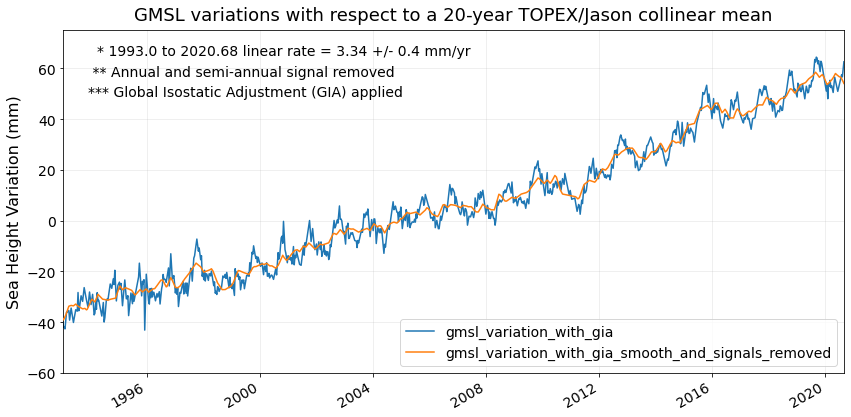

In [15]:
# Plot the GMSL variation (with GIA and annual/semiannual signal removed):
ax = df.gmsl_variation_with_gia.plot(figsize=(14, 7), zorder=2)

# Now plot smoothed + signals removed trend on top:
df.gmsl_variation_with_gia_smooth_and_signals_removed.plot(zorder=3)

# Get the upper and lower bounds of the error region:
error_upper = df.gmsl_variation_with_gia + df.gmsl_variation_with_gia_std
error_lower = df.gmsl_variation_with_gia - df.gmsl_variation_with_gia_std

# Plot the standard deviation of the GMSL variation (no GIA) as error region.
#ax.fill_between(df.index, error_upper, error_lower, color="white", alpha=1, zorder=1)

# Add two footnotes about the data processing:
plt.figtext(0.15, 0.83, '  * 1993.0 to 2020.68 linear rate = 3.34 +/- 0.4 mm/yr')
plt.figtext(0.15, 0.79, ' ** Annual and semi-annual signal removed')
plt.figtext(0.15, 0.75, '*** Global Isostatic Adjustment (GIA) applied')

# Configure plot title, x and y axis labels and limits, and other aesthetics:
ax.set_title("GMSL variations with respect to a 20-year TOPEX/Jason collinear mean", pad=10)
ax.set_ylabel("Sea Height Variation (mm)")
ax.set_xlim(df.index[0], df.index[-1])
ax.set_xlabel(None)
ax.set_ylim(-60, 75)
ax.grid(alpha=0.25)
ax.legend(loc="lower right")

plt.show()

**Time series structure**

The baseline v5.0 merged file is comprised of 1,019 (was 989) 10-day repeat cycles:

```
 001 –  355  TOPEX_Poseidon
 356 –  582  Jason_1
 583 –  865  Jason_2
 866 – 1020  Jason_3
```

## Reformat

This next section of the dataset release demo converts the table into an xarray dataset and loads it with rich metadata from the ASCII file header. You might want to take this step if you need to analyze the GMSL data alongside other datasets stored in common geoscience data formats like netCDF and GeoTIFF.

### Optionally, convert `pandas` to `xarray`

As an end user, you may need to leverage other Python packages besides pandas for your analysis. You may also benefit from writing the data to disk in another format that's more convenient to use or consistent with other datasets that your analysis demands. 

Now we reformat the `pandas.DataFrame` into an `xarray.Dataset` and enrich it with descriptive metadata from the ASCII file header. Then, we write the dataset to disk in netCDF format with CF compliant metadata included.

First, call the xarray convenience function `xarray.from_dataframe` to seamlessly convert the data frame to an `xarray.Dataset`:

In [16]:
ds = df.to_xarray()

print(ds)

<xarray.Dataset>
Dimensions:                                             (time: 1019)
Coordinates:
  * time                                                (time) datetime64[ns] ...
Data variables:
    altimeter_type                                      (time) int64 0 0 ... 0 0
    cycle                                               (time) int64 11 ... 1030
    year                                                (time) float64 1.993e...
    observation_count                                   (time) int64 452600 ....
    observation_count_weighted                          (time) float64 3.274e...
    gmsl_variation                                      (time) float64 -38.59...
    gmsl_variation_std                                  (time) float64 89.86 ...
    gmsl_variation_smooth                               (time) float64 -38.76...
    gmsl_variation_with_gia                             (time) float64 -38.59...
    gmsl_variation_with_gia_std                         (time) float64 89.

### Enrich dataset and variable metadata

Now we add the basic CF treatments to the variables and the dataset. We'll generally follow the guidelines listed here on the PO.DAAC metadata best practices page: https://podaac.jpl.nasa.gov/PO.DAAC_DataManagementPractices#Metadata%20Conventions

The time variable is a big one-we'll start there.

**Variables**

* the *time* variable

Let's create a valid CF time reference that indexes the data arrays against an epoch of `1992-01-01 00:00:00` (the epoch used in other MEaSUREs-SSH products).

Define another function to manipulate the values in the index of the data frame:

In [17]:
epoch = "1992-01-01 00:00:00"

def _time_to_seconds_since_epoch(x, fmt: str="%Y-%m-%d %H:%M:%S"):
    return (x-datetime.strptime(epoch, fmt)).total_seconds()

_time_to_seconds_since_epoch(df.index[0])

31985883.936007

The value shown above should equal the number of seconds since the epoch for the first timestep in the GMSL series.

Apply the function over the entire index of the data frame:

In [18]:
seconds_since_epoch = df.index.to_series().apply(_time_to_seconds_since_epoch)

seconds_since_epoch

time
1993-01-05 04:58:03.936007    3.198588e+07
1993-01-15 02:56:30.912003    3.284259e+07
1993-01-25 00:54:57.887998    3.369930e+07
1993-02-03 22:53:56.399997    3.455604e+07
1993-02-13 20:52:23.375999    3.541274e+07
                                  ...     
2020-07-26 14:05:29.587200    9.015483e+08
2020-08-05 12:04:03.647994    9.024050e+08
2020-08-15 10:02:37.708803    9.032618e+08
2020-08-25 08:01:11.769597    9.041185e+08
2020-09-04 05:59:45.830405    9.049752e+08
Name: time, Length: 1019, dtype: float64

Add CF attributes to the *time* variable (except for the *units* and *calendar* which xarray likes to handle for us, like a true control freak).

In [19]:
ds.time.attrs = {'long_name': "time", 'standard_name': "time"}

print(ds.time)

<xarray.DataArray 'time' (time: 1019)>
array(['1993-01-05T04:58:03.936007000', '1993-01-15T02:56:30.912003000',
       '1993-01-25T00:54:57.887998000', ..., '2020-08-15T10:02:37.708803000',
       '2020-08-25T08:01:11.769597000', '2020-09-04T05:59:45.830405000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-05T04:58:03.936007 ... 2020-09-04T...
Attributes:
    long_name:      time
    standard_name:  time


* variable *long_name*, *units* attributes

Now assign the description of each column (taken from the ASCII file header) to the corresponding variable's metadata in the xarray dataset. It occupies the `long_name` field. Also use an integer attribute to index each variable according to the corresponding column's position in the original ASCII file.

In [20]:
for variable, description in zip(list(df.columns), column_metadata):

    # Split 'description' string into two strings: an index and details.
    column_index, long_name = int(description[:2].strip()), description[2:].strip()

    # Set the 'col_index' and 'long_name' fields for each variable:
    ds[variable].attrs = {'column_index': column_index, 'long_name': long_name}

*If no errors, you're good!* Live dangerously and proceed without checking your work. (We will check it in a moment.)

You'll notice that the units are given in the `long_name` of each variable (almost, those that don't contain units are obvious). In the next cell, I've created an array of strings that we'll use to populate the `units` field of each variable in the same way as we did with the descriptions above:

In [21]:
_units = [None, None, "year", None, None, "mm", "mm", "mm", "mm", "mm", "mm"]

for variable, units in zip(list(df.columns), _units):
    if units:
        ds[variable].attrs.update({'units': units})

Hopefully there were no errors. Confirm that all the attributes look as expected for the *gmsl* variable:

In [22]:
print(ds['gmsl_variation'])

<xarray.DataArray 'gmsl_variation' (time: 1019)>
array([-38.59, -41.97, -41.93, ...,  49.87,  53.62,  55.82])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-05T04:58:03.936007 ... 2020-09-04T...
Attributes:
    column_index:  6
    long_name:     GMSL (Global Isostatic Adjustment (GIA) not applied) varia...
    units:         mm


* identify the *_FillValue*

One final step for variables is to define fill values. 

If we were planning to do some downstream processing as part of an analysis, we might want to forget about the fill value and replace them all with `numpy.nan` to ensure they're ignored in the computations. Because we plan to write this dataset to a CF-compliant netCDF, we should leave the fill values in place and specify a fill value accordingly.

When writing netCDF4 files with xarray, we must specify the fill value on a per-variable basis as part of our call to the `to_netcdf` method of our xarray dataset. We'll do that later. 

In preparation for the final step, get the fill value from the fifth-to-last line in the header:

In [23]:
fill_value = float(hdr[-5].strip().split(": ")[1])
fill_value

99900.0

Now the variables are mostly in good shape. (You could also update the `altimetry_type` to use the CF spec for flag variables. Remember that the first column only stores a binary flag of 0 or 999.)

**Global attributes**

Finally, let's see what other info should be retained from the ASCII file header as global attributes in our enhanced dataset.

Drop the prefixes from all the lines of the header and do some further cleanup, then select the *Abstract*, *citation*, *doi*, and *references* from the ASCII header:

In [24]:
# Clean up the lines in the header in a nested for loop:
hdr = [m for m in [l.replace("HDR", "") for l in hdr] if m!='']

# Get four references from the header as a list of strings:
refs = ["".join(hdr[13:16]), "".join(hdr[16:19]), hdr[18], hdr[11]]

# Select global attributes from the header into a Python dict:
global_attributes = {
    'summary': "".join(hdr[1:10]).strip().replace("  ", " "),
    'id': hdr[11].strip().split("http://dx.doi.org/")[1][:-1],
    'references': "; ".join([r.strip().replace("DOI:", "https://doi.org/") for r in refs]),
    'comment': hdr[-3].strip(),
    'time_coverage_start': np.datetime_as_string(ds.time.min().data).split(".")[0],
    'time_coverage_end': np.datetime_as_string(ds.time.max().data).split(".")[0],
}

# Add some static metadata copied from another MEaSUREs-SSH dataset:
global_attributes.update({
    'title': "Global Mean Sea Level Trend from Integrated Multi-Mission Ocean Altimeters TOPEX/Poseidon Jason-1 and OSTM/Jason-2 Version 5",
    'institution': "NASA Goddard Space Flight Center",
    'reference_document': "Integrated Multi-Mission Ocean Altimeter Data for Climate Research TOPEX/Poseidon, Jason-1, OSTM/Jason-2 and Jason-3 User\'s Handbook, Version 4",
    'creator_name': "Brian D. Beckley, Richard D. Ray",
    'creator_email': "Brian.D.Beckley@nasa.gov, Richard.D.Ray@nasa.gov",
    'project_name': "NASA MEaSUREs - NNH06ZDA001N",
    'mission_name': "Integrated T/P, Jason-1, OSTM/Jason-2 and Jason-3 Altimetry",
    'altimeter_sensor_name': "TOPEX-A, TOPEX-B, Poseidon-1, Poseidon-2, Poseidon-3, Poseidon-3B",
    'radiometer_sensor_name': "TMR (TOPEX/Poseidon Microwave Radiometer), JMR (Jason-1 Microwave Radiometer), AMR (OSTM Advanced Microwave Radiometer), AMR (Jason-3 Advanced Microwave Radiometer)",
    'source_TOPEX': "TOPEX/Poseidon MGDR_B: Benada, J.R. 1997. PO.DAAC Merged GDR (TOPEX/POSEIDON) Generation B Users Handbook, Version 2.0 JPL D-11007",
    'source_Jason-1': "Jason-1 GDR_E: AVISO and PODAAC User Handbook. IGDR and GDR Jason Products SMM-MU-M5-OP-13184-CN (AVISO), JPL D-21352 (PODAAC)  Edition 4",
    'source_OSTM': "OSTM GDR_D: OSTM/Jason-2 Products Handbook, CNES: SALP-MU-M-OP-15815-CN, EUMETSAT: EUM/OPS-JAS/MAN/08/0041, JPL: OSTM-2 9-1237, NOAA/NESDIS: Polar Series/OSTM J400, Issue 1 rev 8, December 1, 2011",
    'source_Jason-3': "Jason-3 GDR_D: Jason-3 Products Handbook, CNES : SALP-MU-M-OP-16118-CN, Issue: 1 rev 2, February 12th, 2016",
    'Conventions': "CF-1.6",
    'keywords': "EARTH SCIENCE > OCEANS > SEA SURFACE TOPOGRAPHY > SEA SURFACE HEIGHT",
    'keywords_vocabulary': "GCMD Science Keywords",
})

# Add all those attributes to the xarray dataset:
ds.attrs = global_attributes

print(ds)

<xarray.Dataset>
Dimensions:                                             (time: 1019)
Coordinates:
  * time                                                (time) datetime64[ns] ...
Data variables:
    altimeter_type                                      (time) int64 0 0 ... 0 0
    cycle                                               (time) int64 11 ... 1030
    year                                                (time) float64 1.993e...
    observation_count                                   (time) int64 452600 ....
    observation_count_weighted                          (time) float64 3.274e...
    gmsl_variation                                      (time) float64 -38.59...
    gmsl_variation_std                                  (time) float64 89.86 ...
    gmsl_variation_smooth                               (time) float64 -38.76...
    gmsl_variation_with_gia                             (time) float64 -38.59...
    gmsl_variation_with_gia_std                         (time) float64 89.

## Write to disk

Finally, let's write the dataset to local disk as a netCDF file. We use the [`to_netcdf`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html) method of the dataset object for that. 

Pay close attention to the options below:

In [25]:
# Default encoding params to be applied to all variables:
defaults = {'zlib': True, '_FillValue': fill_value}

# Collect per-variable encoding dicts in a Python dict:
encoding = {'time': {'zlib': True, '_FillValue': False}}

# Use simple condition to decide to recast problematic int64 data types:
for var in ds.variables:
    enc = {'dtype': str(ds[var].dtype), **defaults}
    if var=="time":
        continue
    if ds[var].dtype=="int64":
        enc.update({'dtype': "int32"})
    encoding[var] = enc

encoding['gmsl_variation']

{'dtype': 'float64', 'zlib': True, '_FillValue': 99900.0}

Write the dataset to local disk with the same name as the text file downloaded from opendap, replacing`.txt` with `.nc`.

In [26]:
filename = basename(opendap_url).replace(".txt", ".nc")
print(f"# Write to disk: {filename}")

ds.to_netcdf(
    path=filename,
    mode="w",
    format="NETCDF4",
    encoding=encoding,
)

# Write to disk: GMSL_TPJAOS_5.0_199209_202009.nc


And admire your work by calling *ncdump* on the new netCDF4 file:

In [27]:
!ncdump -h $filename

netcdf GMSL_TPJAOS_5.0_199209_202009 {
dimensions:
	time = 1019 ;
variables:
	double time(time) ;
		time:_FillValue = 0. ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:units = "seconds since 1993-01-05 04:58:03.936007" ;
		time:calendar = "proleptic_gregorian" ;
	int altimeter_type(time) ;
		altimeter_type:_FillValue = 99900 ;
		altimeter_type:column_index = 1LL ;
		altimeter_type:long_name = "altimeter type 0=dual-frequency  999=single frequency (ie Poseidon-1)" ;
	int cycle(time) ;
		cycle:_FillValue = 99900 ;
		cycle:column_index = 2LL ;
		cycle:long_name = "merged file cycle #" ;
	double year(time) ;
		year:_FillValue = 99900. ;
		year:column_index = 3LL ;
		year:long_name = "year+fraction of year (mid-cycle)" ;
		year:units = "year" ;
	int observation_count(time) ;
		observation_count:_FillValue = 99900 ;
		observation_count:column_index = 4LL ;
		observation_count:long_name = "number of observations" ;
	double observation_count_weighted(time) ;
		observation